# Generate a Noise Model by Bootstrapping
We will use pairs of noisy images $x_i$ and clean pseudo ground truth $s_i$ (created by performing Noise2Void in notebooks `1_N2VTraining.ipynb`) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. No additional, calibration data is used.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../../')
from pn2v import *
import pn2v.gaussianMixtureNoiseModel
import pn2v.histNoiseModel
import pn2v.prediction

### Download data
Download the data from https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `../../../`.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

zipPath="../../../data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data")


### The data

The noise model is a characteristic of your camera. 
The downloaded data folder contains a set of calibration images (For the Convallaria dataset, it is ```20190726_tl_50um_500msec_wf_130EM_FD.tif``` and the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif```). Here we bootstrap a suitable histogram noise model after denoising the noisy images with Noise2Void and then using these denoised images as pseudo GT.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Convallaria_diaphragm/"
dataName = 'convallaria' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif') #Load the appropriate data
nameHistNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'trained_GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'
nameN2VModel = dataName+'_n2v'
net=torch.load(path+"last_"+nameN2VModel+".net")

In [5]:
# This cell is only run if bootstrap mode is selected. This performs N2V denoising for generating pseudoGT.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]
dataTest = observation

for index in range(dataTest.shape[0]):

    im=dataTest[index]
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means = pn2v.prediction.tiledPredict(im, net, ps=256, overlap=48,
                                            device=device, noiseModel=None)
    resultImgs.append(means)
    inputImgs.append(im)
    print ("image:", index)

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
image: 20
image: 21
image: 22
image: 23
image: 24
image: 25
image: 26
image: 27
image: 28
image: 29
image: 30
image: 31
image: 32
image: 33
image: 34
image: 35
image: 36
image: 37
image: 38
image: 39
image: 40
image: 41
image: 42
image: 43
image: 44
image: 45
image: 46
image: 47
image: 48
image: 49
image: 50
image: 51
image: 52
image: 53
image: 54
image: 55
image: 56
image: 57
image: 58
image: 59
image: 60
image: 61
image: 62
image: 63
image: 64
image: 65
image: 66
image: 67
image: 68
image: 69
image: 70
image: 71
image: 72
image: 73
image: 74
image: 75
image: 76
image: 77
image: 78
image: 79
image: 80
image: 81
image: 82
image: 83
image: 84
image: 85
image: 86
image: 87
image: 88
image: 89
image: 90
image: 91
image: 92
image: 93
image: 94
image: 95
image: 96
image: 97
image: 98
image: 99


(100, 1024, 1024)


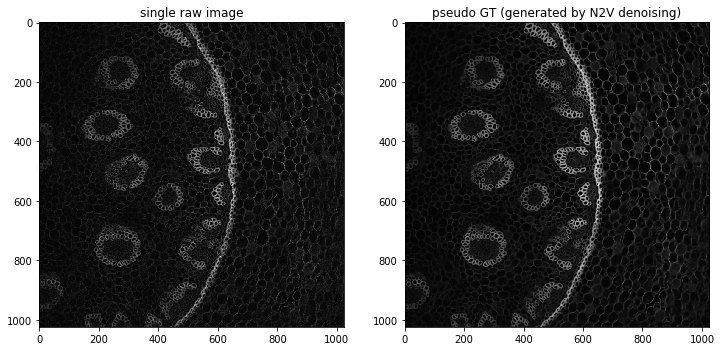

In [6]:
# In bootstrap mode, we estimate pseudo GT by using N2V denoised images.
signal = np.array(resultImgs)   
# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='pseudo GT (generated by N2V denoising)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [7]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 234, 7402
bins = 256

# We are creating the histogram.
# This can take a minute.
histogram = pn2v.histNoiseModel.createHistogram(bins, minVal, maxVal, observation, signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

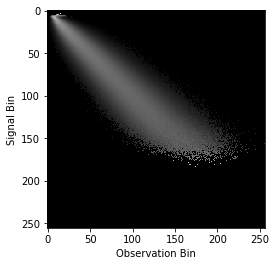

In [8]:
# Let's look at the histogram-based noise model
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [9]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 487.6706848144531
Maximum Signal Intensity is 3228.720950927731


Iterating the noise model training for `n_epoch=2000` and `batchSize=250000` works the best for `Convallaria` dataset. 

In [10]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal, max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 2000, learning_rate = 0.1, name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

0 15.235857963562012
100 6.147412300109863
200 6.14974308013916
300 6.149284362792969
400 6.149086952209473
500 6.145059108734131
600 6.137200832366943
700 6.124576568603516
800 6.125997543334961
900 6.123228073120117
1000 6.12241268157959
1100 6.123538017272949
1200 6.121962070465088
1300 6.120701313018799
1400 6.116930961608887
1500 6.11834192276001
1600 6.122352123260498
1700 6.118558883666992
1800 6.120463848114014
1900 6.12037992477417


### Visualizing the Histogram-based and GMM-based noise models

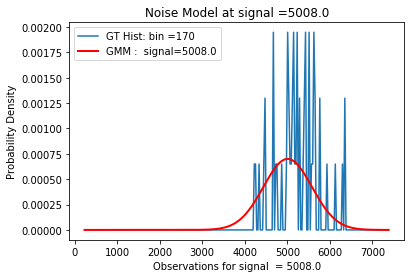

In [11]:
n_bin = 256
index= 170
min_signal=minVal
max_signal=maxVal
binclip=300
histBinSize=(max_signal-min_signal)/n_bin

querySignal_numpy= (index/float(n_bin)*(max_signal-min_signal)+min_signal)
querySignal_numpy+=histBinSize/2
querySignal_torch = torch.from_numpy(np.array(querySignal_numpy)).float().to(device)

idx = torch.from_numpy(np.arange(min_signal, max_signal, histBinSize)).float().to(device)
p=gaussianMixtureNoiseModel.likelihood(idx, querySignal_torch)
pNumpy=p.cpu().detach().numpy()

xvals=np.arange(n_bin)/float(n_bin)*(max_signal-min_signal)+min_signal
xvals+=histBinSize/2 


plt.plot(xvals[:binclip], histogramFD[index,:binclip]/histBinSize, label='GT Hist: bin ='+str(index))
plt.plot(np.arange(min_signal, max_signal,histBinSize)[:binclip], pNumpy[:binclip], label='GMM : '+' signal='+str(np.round(querySignal_numpy,2)),color='red',linewidth=2)
plt.xlabel('Observations for signal  = ' + str(querySignal_numpy))
plt.ylabel('Probability Density')
plt.title("Noise Model at signal =" + str(querySignal_numpy))
plt.legend()